# Inicio
Iremos usar um modelo de rede neural para manipular séries temporais.\
Iremos usar o NeuralProphet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import torch

# from sklearn.metrics import (
#     r2_score,
#     mean_absolute_error,
#     mean_absolute_percentage_error
# )

from neuralprophet.configure import Season
torch.serialization.add_safe_globals([Season])

import neuralprophet

/home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [10]:
codigo = 'BRL=X'
inicio = '2000-01-01'
fim = '2025-09-04'

data = yf.download(codigo, start=inicio, end=fim, multi_level_index=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_331414/1598541041.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [11]:
# Transformando em dataframe
df = pd.DataFrame(data)

# Transformando dados
df = df[['Close']].reset_index()
df.columns = ['ds', 'y']

## Modelo
Iremos treinar o modelo com os dados

In [12]:
df_formatted = pd.DataFrame({
    'ds': pd.to_datetime(df['ds']),
    'y': df['y'].astype(float)
})
df_formatted = df_formatted.dropna()
df_formatted = df_formatted.sort_values('ds').reset_index(drop=True)

In [13]:
modelo = neuralprophet.NeuralProphet(
    growth='linear',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    batch_size=64,
    learning_rate=0.01,
    normalize='standardize',
    trend_reg=0.1,
    trend_reg_threshold=False
)
metrics = modelo.fit(
    df_formatted,
    freq='D',
    validation_df=None,
    progress='bar'
    )

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change

Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 226.39it/s, loss=0.099, v_num=4, MAE=0.301, RMSE=0.400, Loss=0.0941, RegLoss=0.000]   


### Testando modelo

In [14]:
dados_futuros = modelo.make_future_dataframe(df_formatted, periods=365)
previsao_futura = modelo.predict(dados_futuros)

previsoes_historicas = modelo.predict(df_formatted)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.541% of the data.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be remove

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.95it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.541% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be re


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 312.73it/s]


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [15]:
previsao_futura.head()

,ds,y,yhat1,trend,season_daily
0,2025-09-04,None,6.033775,8.111540,-2.077765
1,2025-09-05,None,6.028272,8.112463,-2.084191
2,2025-09-06,None,6.035486,8.113386,-2.077900
3,2025-09-07,None,6.035320,8.114308,-2.078988
4,2025-09-08,None,6.029633,8.115232,-2.085600


In [16]:
modelo.plot_components(previsao_futura)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:283: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




### Visualizando previsão

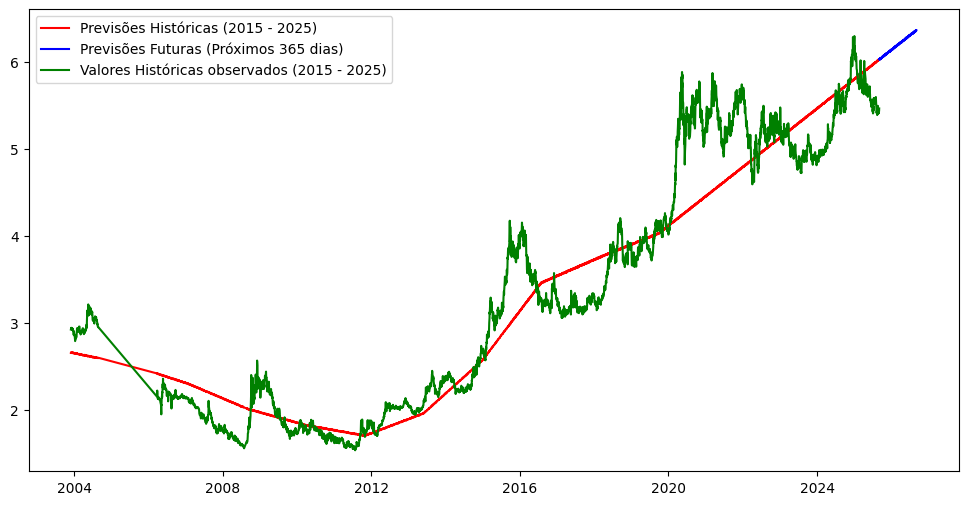

In [17]:
plt.figure(figsize=(12, 6))

# Previsão histórica
plt.plot(
    previsoes_historicas['ds'],
    previsoes_historicas['yhat1'],
    label='Previsões Históricas (2015 - 2025)',
    c='r',
)

# Previsão futura
plt.plot(
    previsao_futura['ds'],
    previsao_futura['yhat1'],
    label='Previsões Futuras (Próximos 365 dias)',
    c='b',
)

# Dados históricos
plt.plot(
    df_formatted['ds'],
    df_formatted['y'],
    label='Valores Históricas observados (2015 - 2025)',
    c='g',
)

plt.legend()
plt.show()